In [1]:
import sys
sys.path.insert(0, "../..")
def set_size(width = "thesis", fraction=1, subplots=(1, 1)):
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')

from os import listdir
from os.path import isfile, join

from module.base.network import Network
from module.simulation.meanfield import MeanField
import module.components.CONST as CONST
from module.simulation.set_meanfield2 import SetMeanField2
from module.simulation.masterequation import MasterEquation
from module.simulation.quick_meanfield2 import QuickMeanField2
from module.simulation.meanfield2 import MeanField2
from module.components.lawrence_dist import LawrenceDist
from module.components.discrete_gaussian1D import DiscreteGaussian1D

from module.components.restricted_gaussian1D import RestrictedGaussian1D
from module.components.p2_4dist import p2_4dist

/tmp/ipykernel_316/2397363.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def calc_rel_freq(data):
    data = data.round()
    phase_space = np.arange(data.min(), data.max() + 1)
    n = []
    N = data.shape[0]
    for i, val in enumerate(phase_space):
        n.append(np.where(data == phase_space[i])[0].shape[0])

    n = np.array(n)
    probs = n/N

    return phase_space, probs

In [3]:
ld = LawrenceDist()
p2dist = p2_4dist()

In [4]:
i = 130 # voltage config
island =  2 # island
voltage_config = np.loadtxt("../../data/cont_comparison/voltage_configs.csv")[i]
kmc_states = np.loadtxt("../../data/cont_comparison/kmc/"+str(i)+"_.csv")
kmc_phase_space, probs_kmc = calc_rel_freq(kmc_states[:, island])
net = Network(4,4,1,[[0,0,0],[3,0,0],[0,3,0],[3,3,0]])
net.set_voltage_config(voltage_config[0:4], 0)

mf = MeanField(net)
mf2 = MeanField2(net, include_covs = False)
qmf2 = QuickMeanField2(net)

In [16]:
# first order

mf_ts = [0]
mf_means = [np.zeros(16)]
dt = 0.05
t = 0
for i in range(900):
    mf_ts.append(t)
    mf_means.append(np.copy(mf.numeric_integration_solve(macrostate = mf_means[-1], N = 1, dt = dt)))

    t += dt

mf_means = np.array(mf_means)

Text(0.5, 0, 'time [ns]')

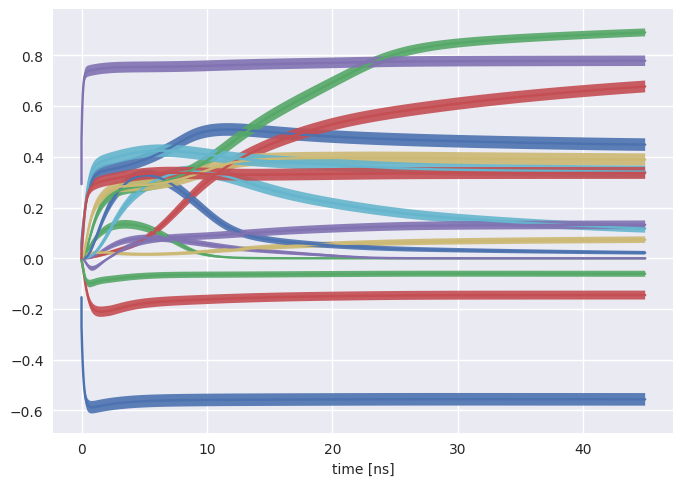

In [19]:
for i in range(16):
    d = mf_means[:,i] - np.floor(mf_means[:,i])
    plt.plot(mf_ts, mf_means[:, i])
    plt.fill_between(mf_ts, mf_means[:,i] - np.sqrt(d * (1 - d)) * 0.05, mf_means[:,i] + np.sqrt(d * (1 - d))*0.05, alpha = 0.9)

plt.xlabel("time [ns]")

In [11]:
# second order cov = 0

# second order

mf2_ts = []
mf2_means = []
mf2_vars = []
dt = 0.05
t = 0
mf2.solve(N = 0, reset = True)
for i in range(900):

    if i % 20 == 0:
        print(i,"/900")

    mf2_ts.append(t)

    mf2.solve(N = 1, dt = dt, reset = False)

    mf2_means.append(np.copy(mf2.means))
    mf2_vars.append(np.copy(mf2.vars))

    t += dt

mf2_means = np.array(mf2_means)
mf2_vars = np.array(mf2_vars)

0 /900
20 /900
40 /900
60 /900
80 /900
100 /900
120 /900
140 /900
160 /900
180 /900
200 /900
220 /900
240 /900
260 /900
280 /900
300 /900
320 /900
340 /900
360 /900
380 /900
400 /900
420 /900
440 /900
460 /900
480 /900
500 /900
520 /900
540 /900
560 /900
580 /900
600 /900
620 /900
640 /900
660 /900
680 /900
700 /900
720 /900
740 /900
760 /900
780 /900
800 /900
820 /900
840 /900
860 /900
880 /900


Text(0.5, 0, 'time [ns]')

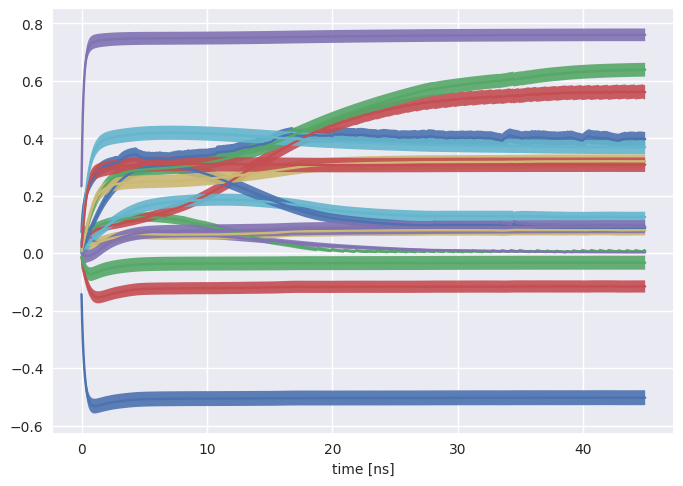

In [12]:
for i in range(16):
    plt.plot(mf2_ts, mf2_means[:, i])
    plt.fill_between(mf2_ts, mf2_means[:,i] - np.sqrt(mf2_vars[:,i]) * 0.05, mf2_means[:,i] + np.sqrt(mf2_vars[:,i])*0.05, alpha = 0.9)

plt.xlabel("time [ns]")

In [24]:
# second order

qmf2_ts = []
qmf2_means = []
qmf2_vars = []
dt = 0.05
t = 0
qmf2.numeric_integration_solve(N = 0, reset = True)
for i in range(900):
    qmf2_ts.append(t)

    qmf2.numeric_integration_solve(N = 1, dt = dt, reset = False)

    qmf2_means.append(np.copy(qmf2.means))
    qmf2_vars.append(np.copy(qmf2.vars))

    t += dt

qmf2_means = np.array(qmf2_means)
qmf2_vars = np.array(qmf2_vars)

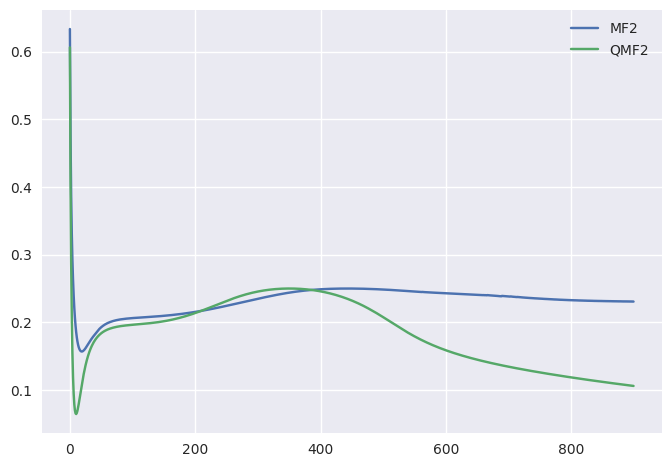

In [84]:
plt.plot(mf2_vars[:,7], label = "MF2")
plt.plot(qmf2_vars[:,7], label = "QMF2")
plt.legend()

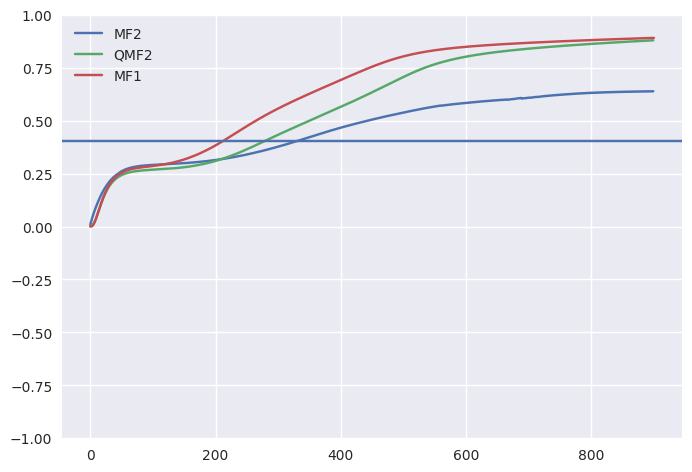

In [83]:
i = 7

plt.plot(mf2_means[:,i], label = "MF2")
plt.plot(qmf2_means[:,i], label = "QMF2")
plt.plot(mf_means[:,i], label = "MF1")
plt.axhline(np.mean(kmc_states, axis = 0)[i])

plt.ylim(-1,1)
plt.legend()

Text(0.5, 0, 'time [ns]')

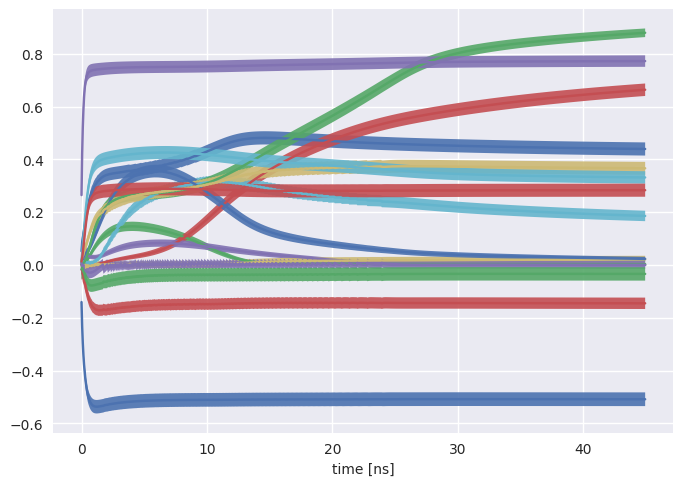

In [25]:
for i in range(16):
    plt.plot(qmf2_ts, qmf2_means[:, i])
    plt.fill_between(qmf2_ts, qmf2_means[:,i] - np.sqrt(qmf2_vars[:,i]) * 0.05, qmf2_means[:,i] + np.sqrt(qmf2_vars[:,i])*0.05, alpha = 0.9)

plt.xlabel("time [ns]")

In [35]:
mf_means[-1,2]

0.6776252802901958

In [36]:
qmf2_means[-1, 2]

0.6637639548014594

In [37]:
mf2_means[-1, 2]

0.5605354075924843

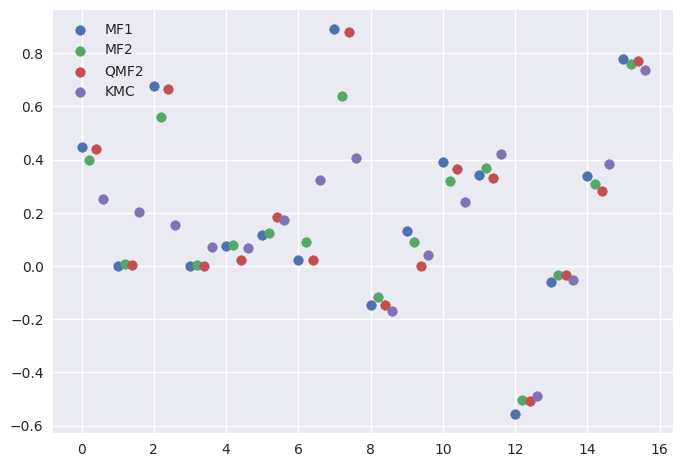

In [34]:
plt.scatter(np.arange(16), mf_means[-1,:], label = "MF1")
plt.scatter(np.arange(16)+0.2, mf2_means[-1,:], label = "MF2")
plt.scatter(np.arange(16)+0.4, qmf2_means[-1,:], label = "QMF2")
plt.scatter(np.arange(16)+ 0.6, np.mean(kmc_states, axis = 0), label = "KMC")

plt.legend()